Dataset

In [ ]:
https://drive.google.com/drive/folders/1s762G9PvR77-qYW8fvG-BpK167AwSpU1?usp=sharing
https://drive.google.com/file/d/1paYbtgHor4b06uPZ9FIRm1W_rNUJrW0V/view?usp=sharing

# 1.Install and Import Data

In [ ]:
!pip install torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install diffusers transformers einops accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
from diffusers import AutoencoderKL
from torchvision.utils import make_grid
import torchvision.utils as vutils
from tqdm.auto import tqdm
from typing import Callable
import os
import pandas as pd
from typing import Tuple, List
import clip
from torchvision.transforms import ToPILImage
from tqdm import trange

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
from torchvision import transforms

class CelebACustom(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.img_dir = os.path.join(root, 'img_align_celeba')
        self.transform = transform
        attr_txt = os.path.join(root, 'list_attr_celeba.txt')
        if os.path.exists(attr_txt):
            self.attr_df = pd.read_csv(
                attr_txt, sep=r'\s+', header=1, index_col=0
            )
        else:
            attr_csv = os.path.join(root, 'list_attr_celeba.csv')
            self.attr_df = pd.read_csv(attr_csv, index_col=0)

        split_txt = os.path.join(root, 'list_eval_partition.txt')
        if os.path.exists(split_txt):
            eval_df = pd.read_csv(
                split_txt, sep=r'\s+', header=1
            )
        else:
            split_csv = os.path.join(root, 'list_eval_partition.csv')
            eval_df = pd.read_csv(split_csv)

        if 'partition' in eval_df.columns:
            part_col = 'partition'
        elif 'split' in eval_df.columns:
            part_col = 'split'
        else:
            part_col = eval_df.columns[1]
        split_map = {'train': 0, 'valid': 1, 'test': 2}
        img_names = eval_df.loc[eval_df[part_col] == split_map[split], eval_df.columns[0]].tolist()
        available = set(os.listdir(self.img_dir))
        self.img_names = [n for n in img_names if n in available]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img = Image.open(os.path.join(self.img_dir, name)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        attr = torch.tensor(self.attr_df.loc[name].values, dtype=torch.float32)
        return img, attr

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
])

train_data = CelebACustom(
    root='./data/celeba',
    split='train',
    transform=transform
)
dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)

print("sample num：", len(train_data))
img, attr = train_data[0]
print("image shape：", img.shape)
print("atrr shape：", attr.shape)



sample num： 162768
image shape： torch.Size([3, 256, 256])
atrr shape： torch.Size([40])


In [ ]:
attr_path = './data/celeba/list_attr_celeba.txt'
df = pd.read_csv(attr_path, sep=r'\s+', header=1, index_col=0)
print("num：", len(df.columns))
print("attr：")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

num： 40
attr：
0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


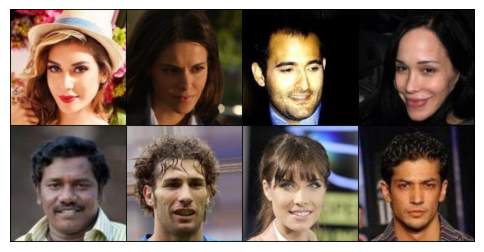

In [ ]:
ch = next(iter(dataloader))[0]
grid = vutils.make_grid(ch[:8], nrow=4)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1,2,0))

# 2.Model

## 2.1 VAE:AutoencoderKL
we use stable diffussion's AutoencoderKL

In [ ]:
#AutoencoderKL
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
vae.eval()

vae_preprocess = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
])
def encode_batch(imgs):
    x = imgs * 2-1  # →[-1,1]
    with torch.no_grad():
        dist = vae.encode(x.to(device)).latent_dist
        z = dist.sample() * vae.config.scaling_factor  # [B,4,64,64]
    return z
def decode_latent(z):
    z_in = z / vae.config.scaling_factor
    out = vae.decode(z_in).sample
    img = (out / 2 + 0.5).clamp(0, 1)
    return img

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

## 2.2 Pretrained clip

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

def get_clip_feats_batch(img_batch, prompts_orig, prompts_tgt):
    pil_list = [ToPILImage()(img.cpu()) for img in img_batch]
    inputs = torch.stack([clip_preprocess(p) for p in pil_list], dim=0).to(device)
    f_img = F.normalize(clip_model.encode_image(inputs), dim=-1)

    toks_o = clip.tokenize(prompts_orig).to(device)
    f_txt_o = F.normalize(clip_model.encode_text(toks_o), dim=-1)

    toks_t = clip.tokenize(prompts_tgt).to(device)
    f_txt_t = F.normalize(clip_model.encode_text(toks_t), dim=-1)
    return f_img, f_txt_o, f_txt_t


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 48.5MiB/s]


#  3.Latent modification

## 3.0 Some helper function

In [ ]:
def sample_attr_paths(root: str, attr_name: str, N: int) -> Tuple[List[str], List[str]]:
    attr_path = os.path.join(root, 'list_attr_celeba.txt')
    img_dir   = os.path.join(root, 'img_align_celeba')

    df = pd.read_csv(attr_path, sep='\s+', header=1, index_col=0)
    pos_df = df[df[attr_name] == 1]
    neg_df = df[df[attr_name] == -1]

    if len(pos_df) < N or len(neg_df) < N:
        raise ValueError( f"not enough {N}，"f"{attr_name}=1 :{len(pos_df)} ，" f"{attr_name}=-1 :{len(neg_df)}")

    pos_list = random.sample(list(pos_df.index), N)
    neg_list = random.sample(list(neg_df.index), N)
    pos_paths = [os.path.join(img_dir, fn) for fn in pos_list]
    neg_paths = [os.path.join(img_dir, fn) for fn in neg_list]
    return pos_paths, neg_paths


In [ ]:
# Helper function for displaying images
def compare_reconstruction(img_orig, img_recon, img_edited, n=5):
    plt.figure(figsize=(n*3, 9))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(img_orig[i].permute(1,2,0).cpu().numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('Original')

        plt.subplot(3, n, n+i+1)
        plt.imshow(img_recon[i].detach().permute(1,2,0).cpu().numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('VAE Recon')

        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(img_edited[i].detach().permute(1,2,0).cpu().numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('Edited')

    plt.show()

In [ ]:
class SimpleCelebA(Dataset):
    def __init__(self, paths: List[str], transform):
        self.paths     = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img)

root = './data/celeba'
attr_name = 'Smiling'
N = 1000
#example: Divided into two datasets: those with smiles and those without smiles.
pos_paths, neg_paths = sample_attr_paths(root, attr_name, N)
pos_loader = DataLoader(SimpleCelebA(pos_paths, transform),batch_size=16, shuffle=False, num_workers=2)
neg_loader = DataLoader(SimpleCelebA(neg_paths, transform),batch_size=16, shuffle=False, num_workers=2)


## 3.1 Clip guided edit

## 3.2 Mapper

## 3.3 Linear Shift

##3.4  Interpolation

## 3.5 lightweight learned mapping

# 4.Save model

## 5.2 Dataset (RUN THIS FIRST)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ./data/celeba
!unzip -q "/content/drive/MyDrive/img_align_celeba.zip" -d ./data/celeba/

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/celeba/list_attr_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_eval_partition.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/identity_CelebA.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_bbox_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_landmarks_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_landmarks_align_celeba.txt" ./data/celeba/

In [ ]:
import os
print(os.listdir('./data/celeba'))
print(os.listdir('./data/celeba/img_align_celeba')[:5])

['identity_CelebA.txt', 'list_bbox_celeba.txt', 'list_landmarks_align_celeba.txt', 'list_attr_celeba.txt', 'img_align_celeba', 'list_landmarks_celeba.txt', 'list_eval_partition.txt']
['114780.jpg', '092455.jpg', '098582.jpg', '014070.jpg', '187392.jpg']
